1. Используя данные из предыдущего ДЗ при помощи edgeR найти гены с
межтканевыми и/или возрастными изменениями экспресии (корректированное
p-value < 0.05, межтканевые отличия должны быть не менее чем в два раза),
возрастные изменения можно считать линейными по возрасту. Используйте
модель ~ tissue + age

In [1]:
d = read.csv('GenewiseCounts.csv',row.names = 1)
dim(d)
d[1:3,]

[1] 51072    10

,B14.5.stringtie.s.bam,B15.5.stringtie.s.bam,B17.5.stringtie.s.bam,B20.stringtie.s.bam,B34.stringtie.s.bam,C14.5.stringtie.s.bam,C15.5.stringtie.s.bam,C17.5.stringtie.s.bam,C20.stringtie.s.bam,C34.stringtie.s.bam
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MSTRG.1,0,0,0,0,0,0,0,0,0,0
MSTRG.2,0,0,0,0,0,0,0,0,0,0
MSTRG.3,0,0,0,0,0,0,0,0,0,0


In [2]:
d = as.matrix(d)
m = data.frame(tissue=substr(colnames(d),1,1),age=as.numeric(sub('.s','.',substr(colnames(d),2,5))))
m$col=ifelse(m$tissue=='B','orange','blue')
rownames(m) = colnames(d)
m

,tissue,age,col
,<chr>,<dbl>,<chr>
B14.5.stringtie.s.bam,B,14.5,orange
B15.5.stringtie.s.bam,B,15.5,orange
B17.5.stringtie.s.bam,B,17.5,orange
B20.stringtie.s.bam,B,20.0,orange
B34.stringtie.s.bam,B,34.0,orange
C14.5.stringtie.s.bam,C,14.5,blue
C15.5.stringtie.s.bam,C,15.5,blue
C17.5.stringtie.s.bam,C,17.5,blue
C20.stringtie.s.bam,C,20.0,blue


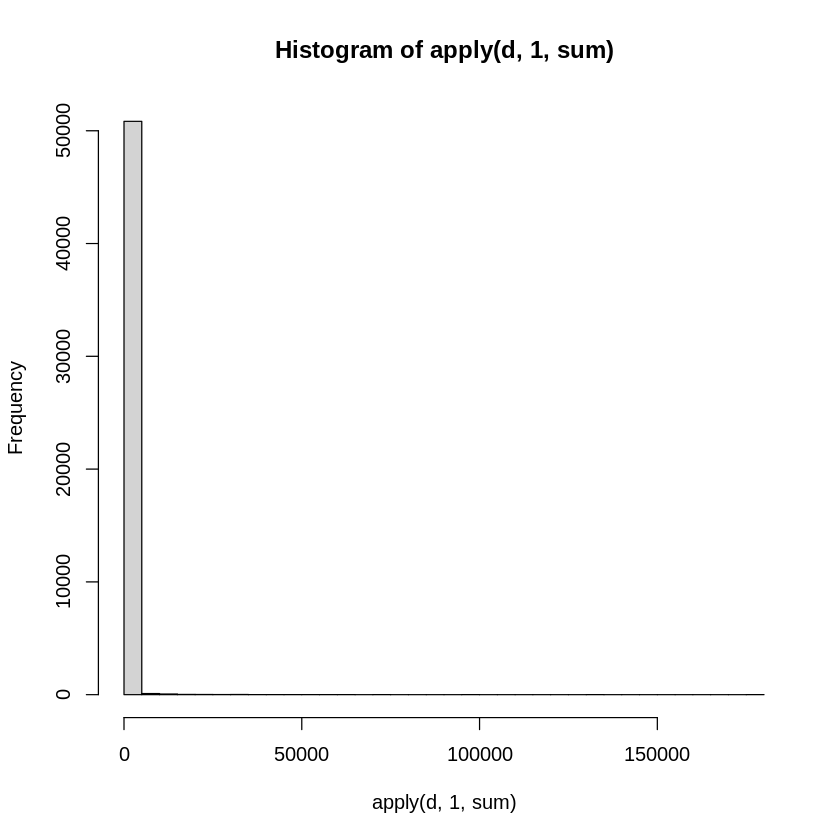

In [3]:
hist(apply(d,1,sum),40)

In [4]:
table(apply(d,1,sum)>9)
d = d[apply(d,1,sum)>9,] # I'll retain only genes with at leats 10 reads in total


FALSE  TRUE 
50112   960 

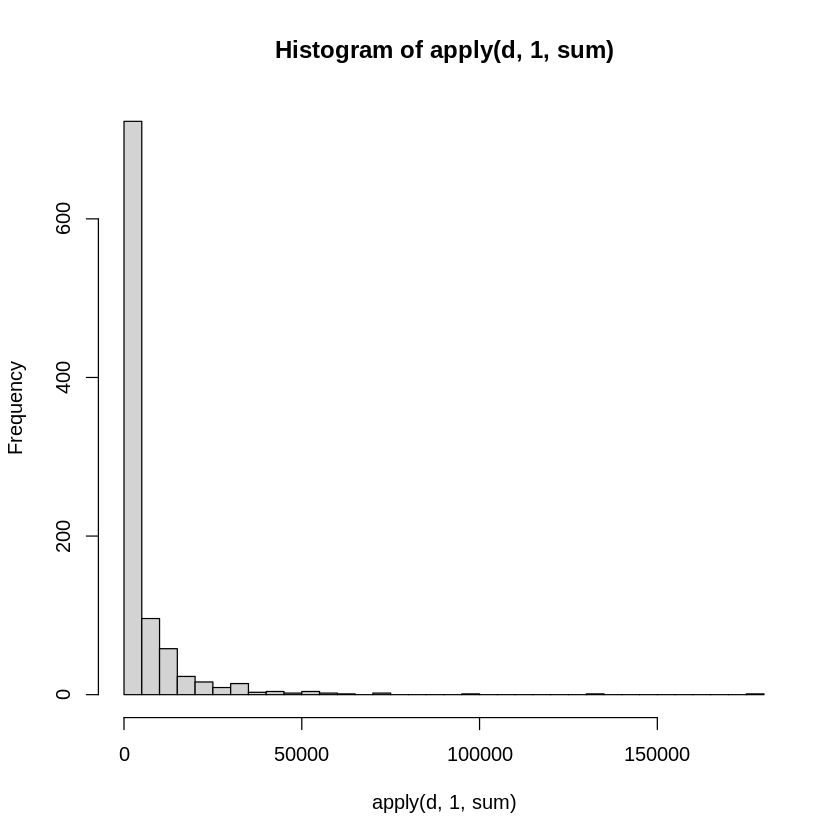

In [5]:
hist(apply(d,1,sum),40)

In [6]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install("edgeR")
library(edgeR)  

edger = DGEList(d) 
edger = calcNormFactors(edger,method='RLE') 
edger$samples # norm.factors are close to 1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’, ‘Rcpp’


Old packages: 'IRkernel', 'bslib', 'callr', 'data.table', 'devtools', 'digest',
  'ggplot2', 'jsonlite', 'lubridate', 'openssl', 'pkgload', 'processx', 'ps',
  'roxygen2', 'sys', 'tibble', 'tidyverse', 'vctrs', 'xfun', 'yaml', 'zip',
  'foreign', 'mgcv', 'rpart'

Loading required package: limma



,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
B14.5.stringtie.s.bam,1,484117,1.0318701
B15.5.stringtie.s.bam,1,463126,1.0437540
B17.5.stringtie.s.bam,1,458627,1.0411547
B20.stringtie.s.bam,1,477379,1.0241826
B34.stringtie.s.bam,1,488630,0.8934972
C14.5.stringtie.s.bam,1,477863,1.0192790
C15.5.stringtie.s.bam,1,457085,1.0422507
C17.5.stringtie.s.bam,1,487676,0.9490369
C20.stringtie.s.bam,1,490115,1.0344154


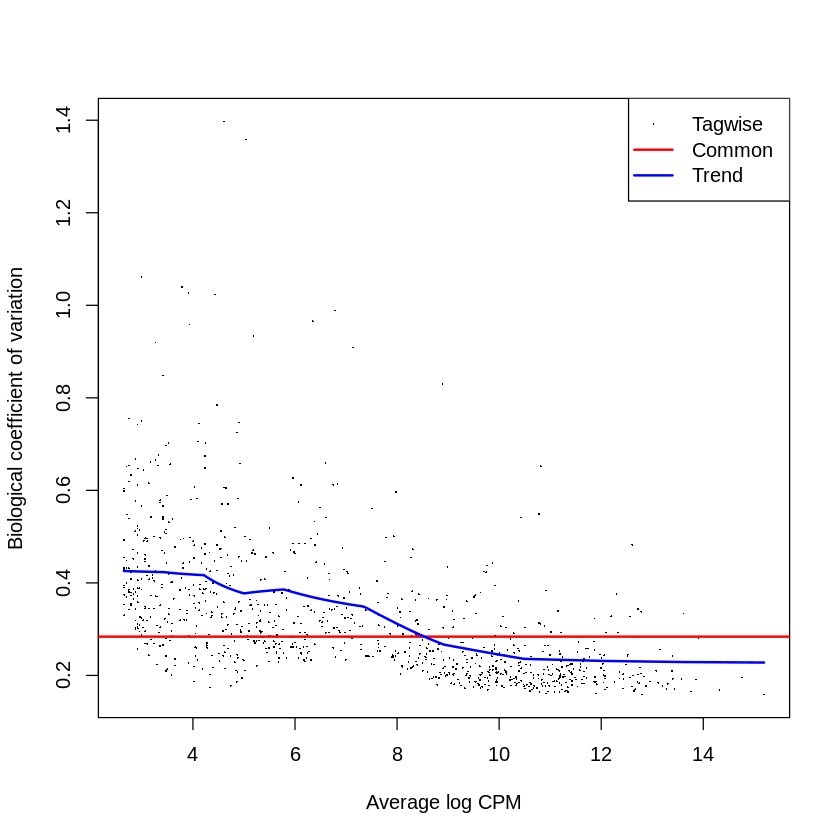

In [7]:
design = model.matrix(~ tissue + age + tissue:age,data = m)
edger = estimateDisp(edger,design) 
plotBCV(edger)
glm = glmFit(edger,design)

In [12]:
pv = cbind(tissue   = glmLRT(glm,2)$table$PValue, 
           age   = glmLRT(glm,3)$table$PValue,
           tissue_age   = glmLRT(glm,4)$table$PValue)
rownames(pv) = rownames(d)
qv = apply(pv,2,p.adjust,m='BH') # сделаем поправку на множественное тестирование
apply(qv < 0.05, 2, sum) # количество генов значимых для каждого фактора

tissue        age tissue_age 
        11        213         11

In [ ]:
cpm = cpm(edger) # посчитаем cpm с учетом RLE нормировки

qv[order(qv[,3])[1:10],] # 10 самых значмых генов для tissue_age

,tissue,age,tissue_age
MSTRG.21938,4.088315e-03,5.019808e-16,2.554711e-06
MSTRG.22048,1.628685e-02,7.649772e-02,1.073646e-05
MSTRG.21999,4.088315e-03,2.867787e-01,9.430751e-05
MSTRG.23285,7.100515e-07,1.465100e-03,1.408327e-03
MSTRG.23205,4.088315e-03,8.070197e-01,3.601250e-03
MSTRG.23190,4.630445e-02,8.169720e-02,5.875117e-03
MSTRG.22220,3.346050e-02,9.765642e-07,1.331549e-02
MSTRG.23167,4.088315e-03,5.368491e-05,1.498219e-02
MSTRG.23317,2.333274e-01,5.587501e-04,1.866748e-02
MSTRG.22112,1.034401e-01,9.746943e-03,2.706731e-02


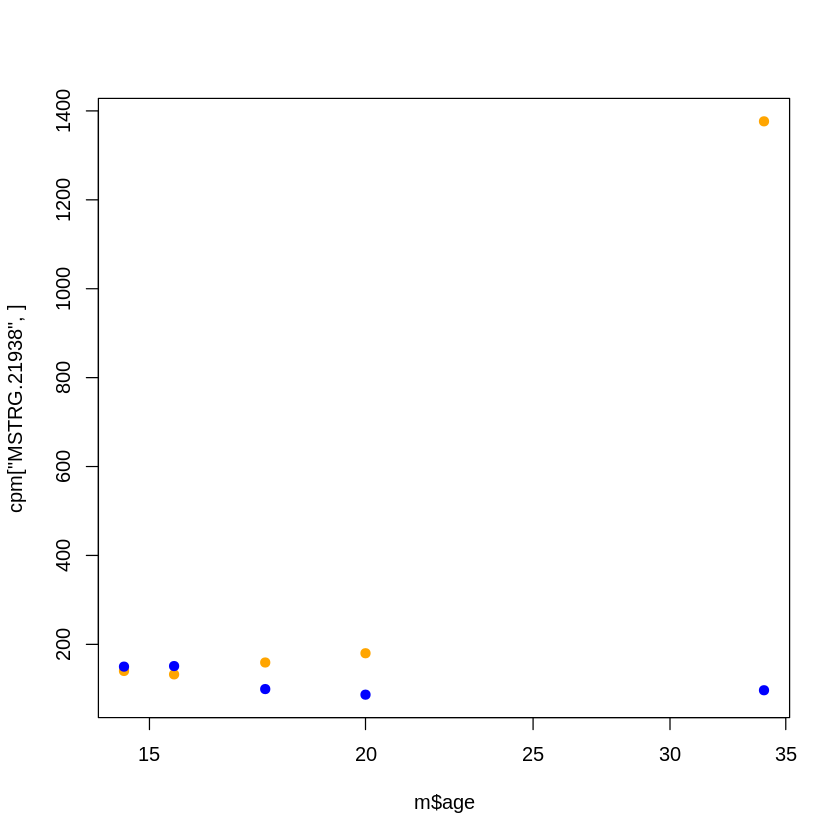

In [ ]:
plot(m$age,cpm['MSTRG.21938',],pch=19,col=m$col,log='x')

2. Скластеризуйте гены значимые хотя бы по одному фактору при помощи
иерархической кластеризации (расстояние 1 — коэффициент корреляции
Спирмана) в 6 кластеров

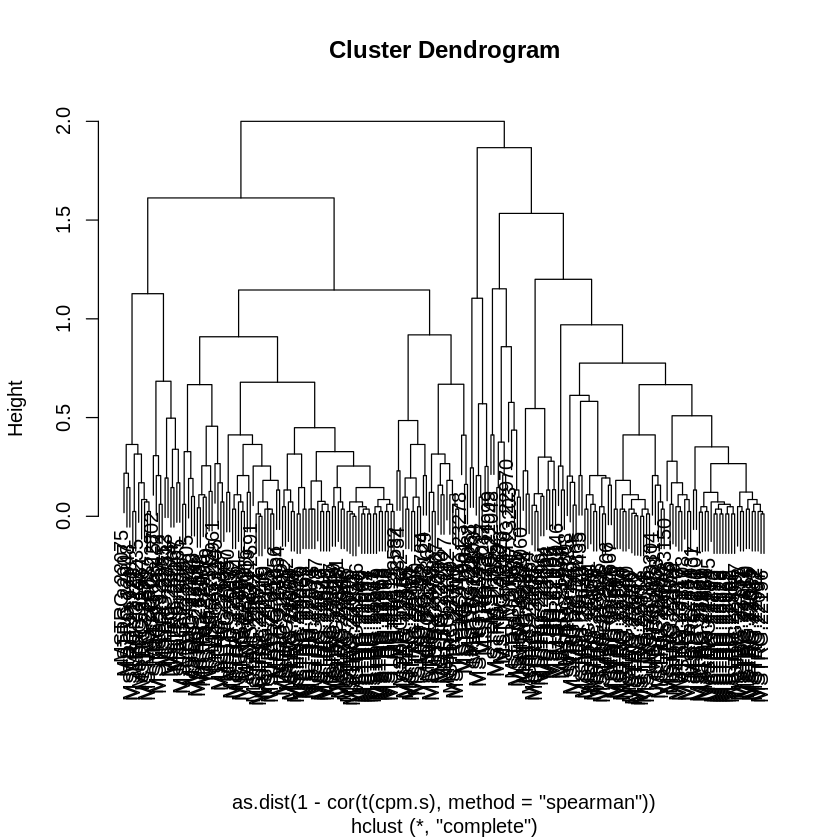

In [ ]:
cpm.s = cpm[apply(qv,1,min)<0.05,] # take significant genes
cpm.s = t(scale(t(cpm.s))) # z-score

hcl = hclust(as.dist(1-cor(t(cpm.s), method='spearman'))) # иерархическая кластеризация

plot(hcl)

In [ ]:
cl = cutree(hcl,6) # режем дерево на 6 кластеров
table(cl) # количество генов в кластерах

cl
 1  2  3  4  5  6 
98 71 20  7 11 12 

3. Отшкалируйте экспрессию каждого гена к среднему ноль и дисперсии один (z-
score). Нарисуйте для каждого кластера зависимость среднего z-score от возраста для обоих тканей

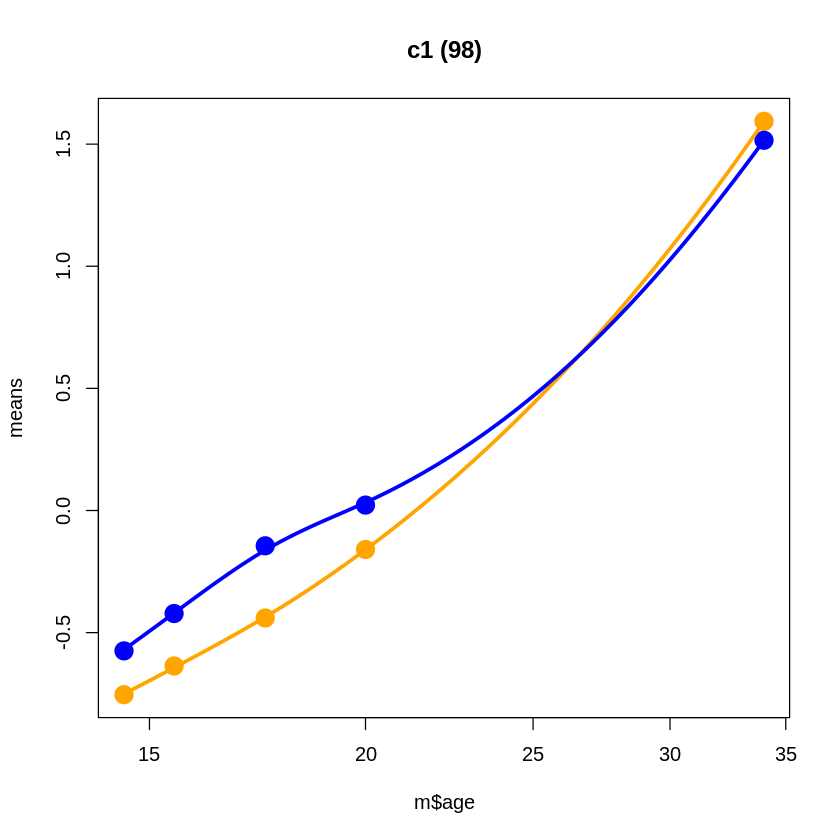

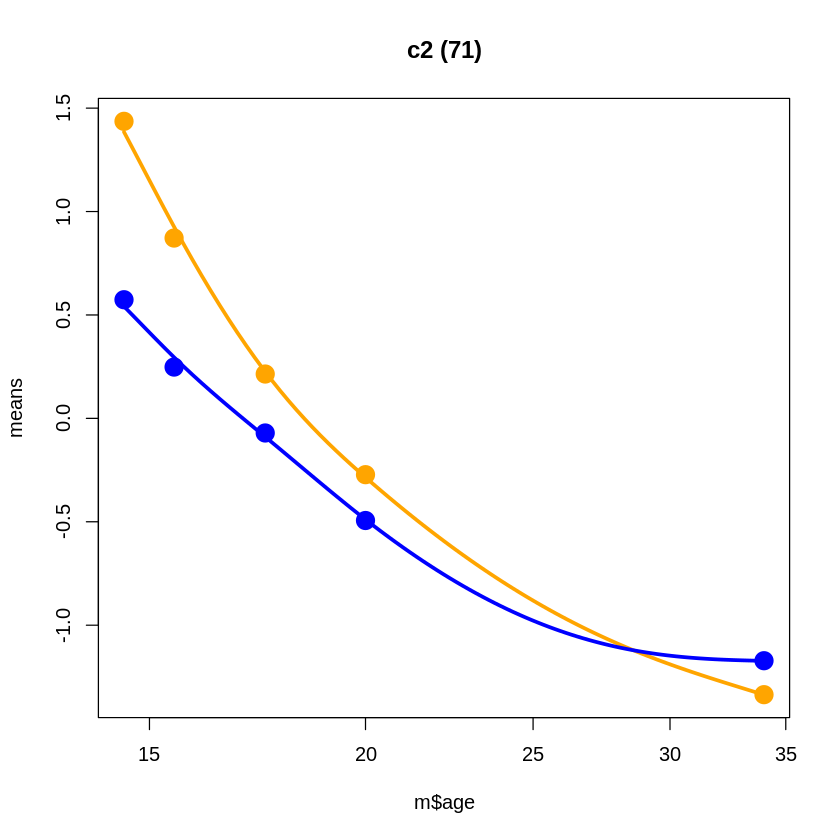

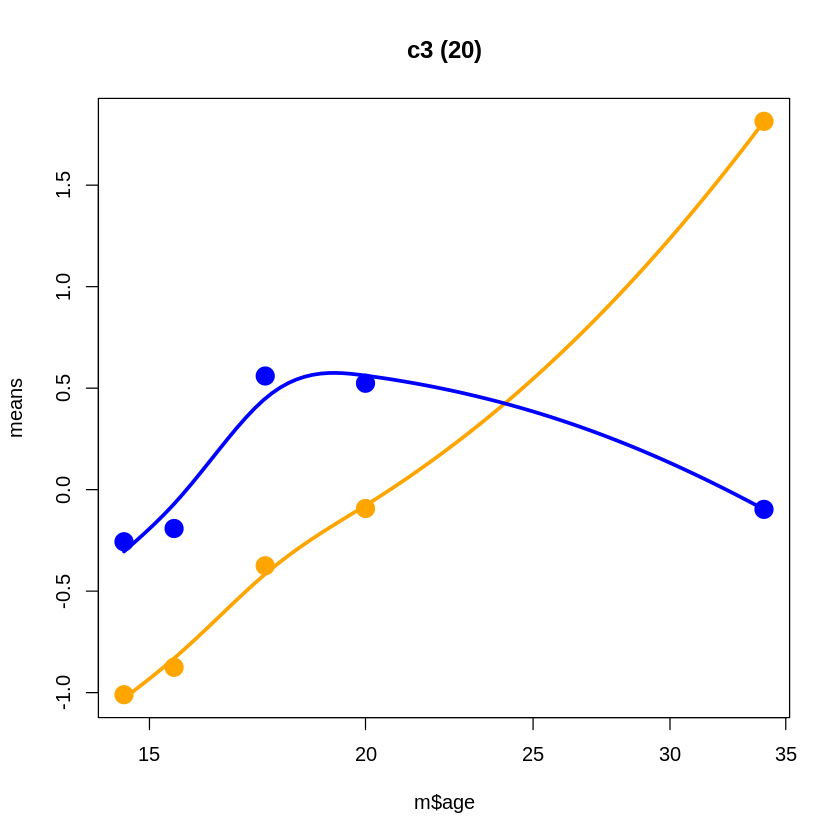

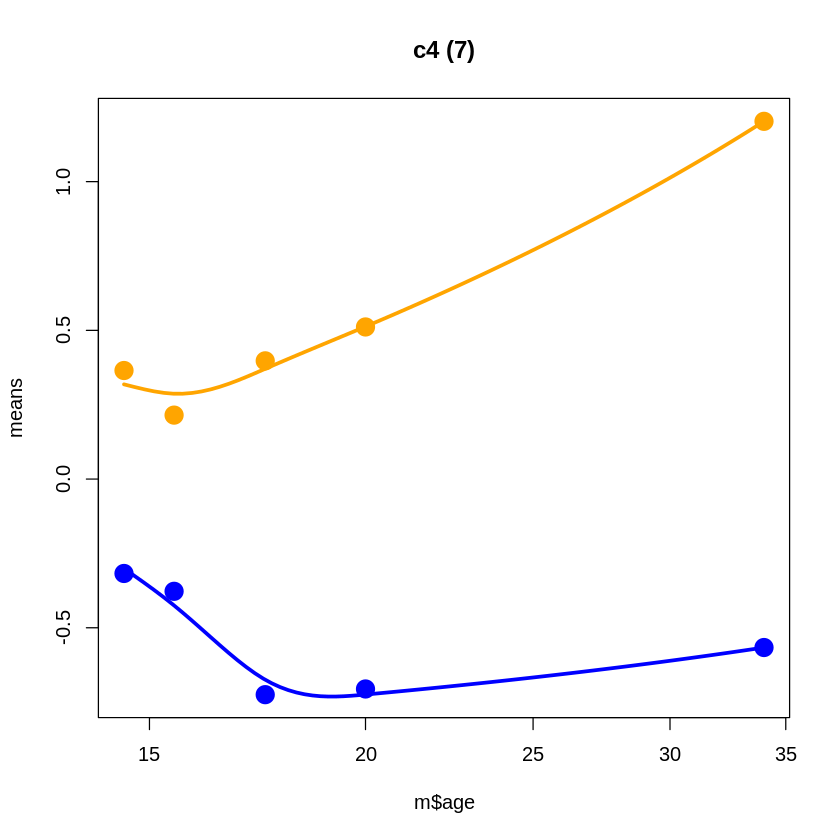

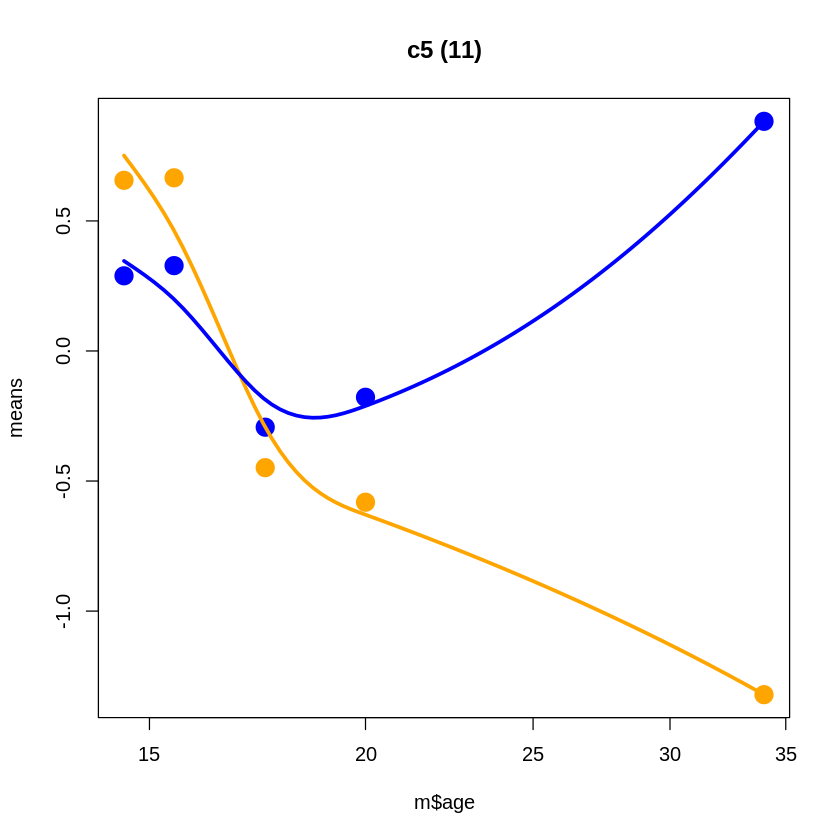

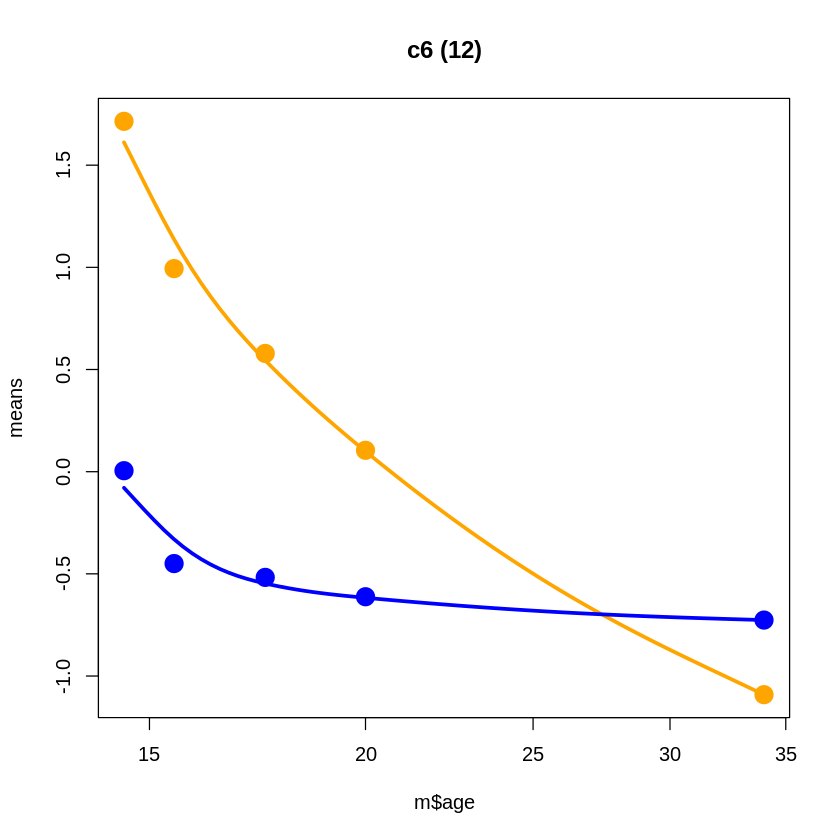

In [ ]:
clusters <- c('c1','c2','c3','c4','c5','c6')
for(i in 1:6) {   
  means = apply(cpm.s[cl==i,,drop=F],2,mean)  # средние экспресси для данного кластера
  plot(m$age,means,pch=19,col=m$col,main=paste0(clusters[i],' (',sum(cl==i),')'),log='x',cex=2) # рисуем средние занчения
  for(t in unique(m$tissue)){  # перебираем ткани 
    f = m$tissue == t # отбираем образцы относящиеся к данной ткани
    ss = smooth.spline(m$age[f],means[f],df=4) # апроксимируем зависимость сплайном
    ss = predict(ss,seq(min(m$age),max(m$age),length.out=100)) # интерполируем
    lines(ss,lwd=3,col=m$col[f][1]) # рисуем апроксимацию
  }
}